In [12]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any, Optional
import re
import time
import os
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
import torch
from rank_bm25 import BM25Okapi
import spacy
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer

# Импортируем классы из вашего pipeline
from pipeline_file import (
    ArticleDownloader, 
    TextPreprocessor, 
    EmbeddingManager, 
    QdrantManager, 
    AnswerGenerator, 
    DocumentationQA
)

# Загрузим данные и оценим текущее состояние системы

1. Загрузка и подготовка данных

Сначала загрузим данные и подготовим их для тестирования различных подходов ретривала:

In [13]:
# Загружаем вопросы из CSV файла
def load_questions():
    df = pd.read_csv('texts_with_answers.csv')
    return df['question'].tolist()

# Загружаем статьи
def load_articles():
    downloader = ArticleDownloader()
    preprocessor = TextPreprocessor()
    
    print("Загружаем статьи...")
    articles = downloader.get_all_articles()
    
    all_paragraphs = []
    for article in articles:
        # Извлечение параграфов из markdown
        paragraphs = preprocessor.extract_text_from_md(article['content'])
        
        # Фильтрация специфичных заголовков
        filtered_paragraphs = preprocessor.filter_paragraphs(paragraphs, article['name'])
        
        # Добавление в общий список
        for paragraph in filtered_paragraphs:
            all_paragraphs.append({
                'name': article['name'],
                'text': paragraph
            })
    
    print(f"Загружено {len(all_paragraphs)} параграфов из {len(articles)} статей")
    return all_paragraphs

# Загружаем данные
questions = load_questions()
paragraphs = load_articles()

print(f"Загружено {len(questions)} вопросов")
print(f"Первые 3 вопроса:")
for i, q in enumerate(questions[:3]):
    print(f"{i+1}. {q}")

Загружаем статьи...
Загружено 292 параграфов из 12 статей
Загружено 120 вопросов
Первые 3 вопроса:
1. What is a collection in the context of Qdrant?
2. What must be true about the dimensionality of vectors within a single collection?
3. How does Qdrant support different metrics for comparing vectors?


2. Реализация различных методов ретривала

Теперь реализуем различные методы ретривала для сравнения их производительности:

In [14]:
class BaseRetriever:
    """Базовый класс для всех ретриверов"""
    
    def __init__(self, paragraphs):
        self.paragraphs = paragraphs
        self.is_initialized = False
    
    def initialize(self):
        """Подготовка ретривера к использованию"""
        pass
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
        """Получение наиболее релевантных документов для запроса"""
        pass
    
    def get_name(self) -> str:
        """Название ретривера для отображения в результатах"""
        return "Base Retriever"


class DenseRetriever(BaseRetriever):
    """Ретривер на основе плотных эмбеддингов (из исходного пайплайна)"""
    
    def __init__(self, paragraphs, embedding_model='intfloat/multilingual-e5-large'):
        super().__init__(paragraphs)
        self.embedding_model = embedding_model
        self.embedding_manager = EmbeddingManager()
        self.qdrant_manager = QdrantManager()
        
    def initialize(self):
        if self.is_initialized:
            return
        
        # Инициализация коллекции Qdrant
        print(f"Инициализация DenseRetriever с моделью {self.embedding_model}...")
        self.qdrant_manager.initialize_collection(vector_size=1024)
        # Динамическое определение размерности векторов
        vector_size = self.embedding_manager.get_vector_size()
        
        self.qdrant_manager.initialize_collection(vector_size=vector_size)
        
        # Добавление документов в Qdrant партиями
        batch_size = 100
        for i in tqdm(range(0, len(self.paragraphs), batch_size), desc="Вычисление эмбеддингов"):
            batch = self.paragraphs[i:i + batch_size]
            texts = [item['text'] for item in batch]
            
            # Вычисление эмбеддингов
            embeddings = self.embedding_manager.compute_embeddings(texts)
            
            # Подготовка payload
            payloads = [
                {
                    'text': item['text'],
                    'name': item['name']
                }
                for item in batch
            ]
            
            # Добавление в Qdrant
            self.qdrant_manager.upsert_batch(i, embeddings, payloads)
        
        self.is_initialized = True
        print("DenseRetriever инициализирован")
        
        # Добавление документов в Qdrant партиями
        batch_size = 100
        for i in tqdm(range(0, len(self.paragraphs), batch_size), desc="Вычисление эмбеддингов"):
            batch = self.paragraphs[i:i + batch_size]
            texts = [item['text'] for item in batch]
            
            # Вычисление эмбеддингов
            embeddings = self.embedding_manager.compute_embeddings(texts)
            
            # Подготовка payload
            payloads = [
                {
                    'text': item['text'],
                    'name': item['name']
                }
                for item in batch
            ]
            
            # Добавление в Qdrant
            self.qdrant_manager.upsert_batch(i, embeddings, payloads)
        
        self.is_initialized = True
        print("DenseRetriever инициализирован")
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
        if not self.is_initialized:
            self.initialize()
        
        # Вычисление эмбеддинга для запроса
        query_vector = self.embedding_manager.compute_single_embedding(query)
        
        # Поиск похожих документов
        results = self.qdrant_manager.search(query_vector, limit=top_k)
        
        return [
            {
                'text': hit['text'],
                'name': hit['name'],
                'score': hit['score']
            } 
            for hit in results
        ]
    
    def get_name(self) -> str:
        return f"Dense Retriever ({self.embedding_model.split('/')[-1]})"


class BM25Retriever(BaseRetriever):
    """Ретривер на основе алгоритма BM25 (sparse retrieval)"""
    
    def __init__(self, paragraphs):
        super().__init__(paragraphs)
        self.tokenized_corpus = None
        self.bm25 = None
    
    def initialize(self):
        if self.is_initialized:
            return
        
        print("Инициализация BM25Retriever...")
        
        # Токенизация корпуса
        texts = [item['text'] for item in self.paragraphs]
        tokenized_corpus = [doc.lower().split() for doc in texts]
        self.tokenized_corpus = tokenized_corpus
        
        # Создание объекта BM25
        self.bm25 = BM25Okapi(tokenized_corpus)
        
        self.is_initialized = True
        print("BM25Retriever инициализирован")
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
        if not self.is_initialized:
            self.initialize()
        
        # Токенизация запроса
        tokenized_query = query.lower().split()
        
        # Получение скоров для каждого документа
        doc_scores = self.bm25.get_scores(tokenized_query)
        
        # Сортировка документов по скору и выбор top_k
        top_indices = np.argsort(doc_scores)[::-1][:top_k]
        
        # Формирование результатов
        results = []
        for idx in top_indices:
            results.append({
                'text': self.paragraphs[idx]['text'],
                'name': self.paragraphs[idx]['name'],
                'score': float(doc_scores[idx])
            })
        
        return results
    
    def get_name(self) -> str:
        return "BM25 Retriever"


class HybridRetriever(BaseRetriever):
    """Гибридный ретривер, объединяющий BM25 и Dense эмбеддинги"""
    
    def __init__(self, paragraphs, embedding_model='intfloat/multilingual-e5-large', 
                 dense_weight=0.7, sparse_weight=0.3):
        super().__init__(paragraphs)
        self.dense_retriever = DenseRetriever(paragraphs, embedding_model)
        self.sparse_retriever = BM25Retriever(paragraphs)
        self.dense_weight = dense_weight
        self.sparse_weight = sparse_weight
    
    def initialize(self):
        if self.is_initialized:
            return
        
        print(f"Инициализация HybridRetriever (dense_weight={self.dense_weight}, sparse_weight={self.sparse_weight})...")
        self.dense_retriever.initialize()
        self.sparse_retriever.initialize()
        
        self.is_initialized = True
        print("HybridRetriever инициализирован")
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
        if not self.is_initialized:
            self.initialize()
        
        # Получаем результаты от обоих ретриверов (запрашиваем больше документов)
        dense_results = self.dense_retriever.retrieve(query, top_k=top_k*2)
        sparse_results = self.sparse_retriever.retrieve(query, top_k=top_k*2)
        
        # Объединяем результаты
        combined_results = {}
        
        # Нормализуем скоры из sparse ретривера (BM25)
        if sparse_results:
            max_sparse_score = max([r['score'] for r in sparse_results])
            for r in sparse_results:
                r['score'] = r['score'] / max_sparse_score if max_sparse_score > 0 else 0
        
        # Добавляем результаты из dense ретривера
        for r in dense_results:
            doc_id = r['text'][:100]  # Используем префикс текста как уникальный идентификатор
            combined_results[doc_id] = {
                'text': r['text'],
                'name': r['name'],
                'dense_score': r['score'],
                'sparse_score': 0.0
            }
        
        # Добавляем результаты из sparse ретривера
        for r in sparse_results:
            doc_id = r['text'][:100]
            if doc_id in combined_results:
                combined_results[doc_id]['sparse_score'] = r['score']
            else:
                combined_results[doc_id] = {
                    'text': r['text'],
                    'name': r['name'],
                    'dense_score': 0.0,
                    'sparse_score': r['score']
                }
        
        # Вычисляем общий скор как взвешенную сумму
        for doc_id, data in combined_results.items():
            data['score'] = (self.dense_weight * data['dense_score'] + 
                             self.sparse_weight * data['sparse_score'])
        
        # Сортируем по общему скору и выбираем top_k
        sorted_results = sorted(combined_results.values(), key=lambda x: x['score'], reverse=True)[:top_k]
        
        # Формируем результаты
        results = []
        for item in sorted_results:
            results.append({
                'text': item['text'],
                'name': item['name'],
                'score': item['score'],
                'dense_score': item['dense_score'],
                'sparse_score': item['sparse_score']
            })
        
        return results
    
    def get_name(self) -> str:
        return f"Hybrid Retriever (dense={self.dense_weight}, sparse={self.sparse_weight})"


class RerankerRetriever(BaseRetriever):
    """Ретривер с двухэтапным поиском: сначала получаем кандидатов, затем реранжируем их"""
    
    def __init__(self, paragraphs, base_retriever=None, reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2"):
        super().__init__(paragraphs)
        self.base_retriever = base_retriever if base_retriever else DenseRetriever(paragraphs)
        self.reranker_model_name = reranker_model
        self.reranker = None
    
    def initialize(self):
        if self.is_initialized:
            return
        
        print(f"Инициализация RerankerRetriever с моделью {self.reranker_model_name}...")
        # Инициализируем базовый ретривер
        self.base_retriever.initialize()
        
        # Загружаем модель reranker
        try:
            from sentence_transformers import CrossEncoder
            self.reranker = CrossEncoder(self.reranker_model_name)
            print("Модель реранкера загружена")
        except ImportError:
            print("Для использования RerankerRetriever установите sentence-transformers: pip install sentence-transformers")
            raise
        
        self.is_initialized = True
        print("RerankerRetriever инициализирован")
    
    def retrieve(self, query: str, top_k: int = 3, candidates_k: int = 10) -> List[Dict[str, Any]]:
        if not self.is_initialized:
            self.initialize()
        
        # Получаем кандидатов с помощью базового ретривера
        candidates = self.base_retriever.retrieve(query, top_k=candidates_k)
        
        # Подготавливаем пары для реранжирования
        pairs = [(query, candidate['text']) for candidate in candidates]
        
        # Получаем скоры от реранкера
        reranker_scores = self.reranker.predict(pairs)
        
        # Объединяем результаты с новыми скорами
        for i, candidate in enumerate(candidates):
            candidate['reranker_score'] = float(reranker_scores[i])
            candidate['original_score'] = candidate['score']
            candidate['score'] = candidate['reranker_score']  # Заменяем оригинальный скор на скор реранкера
        
        # Сортируем по скору реранкера и выбираем top_k
        reranked_results = sorted(candidates, key=lambda x: x['reranker_score'], reverse=True)[:top_k]
        
        return reranked_results
    
    def get_name(self) -> str:
        return f"Reranker ({self.base_retriever.get_name()} + {self.reranker_model_name.split('/')[-1]})"

3. Оценка качества ретривала

Теперь реализуем функции для оценки качества ретривала:

In [15]:
def evaluate_retriever(retriever, questions, ground_truth=None, top_k=3, n_questions=None):
    """Оценка качества ретривера на заданных вопросах"""
    if not retriever.is_initialized:
        retriever.initialize()
    
    if n_questions and n_questions < len(questions):
        selected_questions = questions[:n_questions]
    else:
        selected_questions = questions
    
    results = []
    times = []
    precision_at_k = []
    recall_at_k = []
    ndcg_at_k = []
    
    print(f"Оценка {retriever.get_name()} на {len(selected_questions)} вопросах...")
    for i, question in enumerate(tqdm(selected_questions)):
        # Засекаем время
        start_time = time.time()
        
        # Получаем результаты
        retrieved_docs = retriever.retrieve(question, top_k=top_k)
        
        # Вычисляем время
        retrieval_time = time.time() - start_time
        times.append(retrieval_time)
        
        # Если есть информация о релевантности, вычисляем метрики
        if ground_truth and i in ground_truth:
            relevant_docs = ground_truth[i]
            
            # Вычисляем точность (Precision@K)
            retrieved_ids = [doc['text'][:100] for doc in retrieved_docs]  # Используем начало текста как ID
            relevant_ids = [doc[:100] for doc in relevant_docs]
            
            # Precision@K - доля релевантных документов среди найденных
            relevant_retrieved = sum(1 for doc_id in retrieved_ids if doc_id in relevant_ids)
            precision = relevant_retrieved / len(retrieved_docs) if retrieved_docs else 0
            precision_at_k.append(precision)
            
            # Recall@K - доля найденных релевантных документов от всех релевантных
            recall = relevant_retrieved / len(relevant_ids) if relevant_ids else 0
            recall_at_k.append(recall)
            
            # NDCG@K - нормализованный дисконтированный кумулятивный выигрыш
            dcg = 0
            idcg = 0
            
            # DCG = rel₁ + ∑ᵏᵢ₌₂ relᵢ/log₂(i)
            for j, doc_id in enumerate(retrieved_ids):
                rel = 1 if doc_id in relevant_ids else 0
                if j == 0:
                    dcg += rel
                else:
                    dcg += rel / np.log2(j + 1)
            
            # IDCG - идеальный DCG (если все найденные документы релевантны)
            ideal_rels = sorted([1 if doc_id in relevant_ids else 0 for doc_id in retrieved_ids], reverse=True)
            for j, rel in enumerate(ideal_rels):
                if j == 0:
                    idcg += rel
                else:
                    idcg += rel / np.log2(j + 1)
            
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_at_k.append(ndcg)
        
        # Сохраняем результаты
        result = {
            'question_id': i,
            'question': question,
            'retrieved_docs': retrieved_docs,
            'retrieval_time': retrieval_time
        }
        
        # Добавляем метрики если есть ground truth
        if ground_truth and i in ground_truth:
            result['precision'] = precision
            result['recall'] = recall
            result['ndcg'] = ndcg
            
        results.append(result)
    
    # Вычисляем агрегированные метрики
    avg_time = sum(times) / len(times)
    metrics = {
        'avg_time': avg_time,
        'max_time': max(times),
        'min_time': min(times)
    }
    
    # Добавляем метрики качества если есть ground truth
    if ground_truth and precision_at_k:
        metrics['avg_precision'] = sum(precision_at_k) / len(precision_at_k)
        metrics['avg_recall'] = sum(recall_at_k) / len(recall_at_k)
        metrics['avg_ndcg'] = sum(ndcg_at_k) / len(ndcg_at_k)
    
    print(f"Средняя скорость ретривала: {avg_time:.4f} сек")
    if ground_truth and precision_at_k:
        print(f"Средний Precision@{top_k}: {metrics['avg_precision']:.4f}")
        print(f"Средний Recall@{top_k}: {metrics['avg_recall']:.4f}")
        print(f"Средний NDCG@{top_k}: {metrics['avg_ndcg']:.4f}")
    
    return results, metrics


def compare_retrievers(questions, paragraphs, ground_truth=None, n_questions=10, top_k=3):
    """Сравнение различных ретриверов"""
    # Создаем ретриверы
    retrievers = [
        DenseRetriever(paragraphs),
        BM25Retriever(paragraphs),
        HybridRetriever(paragraphs, dense_weight=0.7, sparse_weight=0.3),
        RerankerRetriever(paragraphs, base_retriever=HybridRetriever(paragraphs))
    ]
    # Подготовка ground truth для оценки
    ground_truth = prepare_ground_truth(questions, paragraphs, n_questions)
    
    # Оцениваем каждый ретривер
    all_results = {}
    all_metrics = {}
    for retriever in retrievers:
        results, metrics = evaluate_retriever(retriever, questions, ground_truth, n_questions=n_questions, top_k=top_k)
        all_results[retriever.get_name()] = results
        all_metrics[retriever.get_name()] = metrics
    
    return all_results, all_metrics


def visualize_results(all_results, all_metrics, top_k=3):
    """Визуализация результатов сравнения ретриверов"""
    retrievers = list(all_metrics.keys())
    
    # Создаем фигуру с несколькими графиками
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Сравнение ретриверов', fontsize=16)
    
    # График времени ретривала
    avg_times = [all_metrics[retriever]['avg_time'] for retriever in retrievers]
    axes[0, 0].bar(retrievers, avg_times, color='skyblue')
    axes[0, 0].set_title('Среднее время ретривала')
    axes[0, 0].set_ylabel('Время (сек)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Проверяем, есть ли метрики качества
    if 'avg_precision' in all_metrics[retrievers[0]]:
        # График Precision@K
        precisions = [all_metrics[retriever]['avg_precision'] for retriever in retrievers]
        axes[0, 1].bar(retrievers, precisions, color='lightgreen')
        axes[0, 1].set_title(f'Средний Precision@{top_k}')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # График Recall@K
        recalls = [all_metrics[retriever]['avg_recall'] for retriever in retrievers]
        axes[1, 0].bar(retrievers, recalls, color='salmon')
        axes[1, 0].set_title(f'Средний Recall@{top_k}')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # График NDCG@K
        ndcgs = [all_metrics[retriever]['avg_ndcg'] for retriever in retrievers]
        axes[1, 1].bar(retrievers, ndcgs, color='gold')
        axes[1, 1].set_title(f'Средний NDCG@{top_k}')
        axes[1, 1].set_ylabel('NDCG')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Выводим таблицу с метриками
    metrics_df = pd.DataFrame(all_metrics).T
    print("\nТаблица метрик:")
    display(metrics_df)
    
    # Сравнение качества ретривалов для нескольких вопросов
    sample_questions = min(5, len(all_results[retrievers[0]]))
    
    for q_idx in range(sample_questions):
        print(f"\n\nПример #{q_idx+1}")
        question = all_results[retrievers[0]][q_idx]['question']
        print(f"Вопрос: {question}")
        
        for retriever_name in retrievers:
            print(f"\n{retriever_name}:")
            
            retrieval_result = all_results[retriever_name][q_idx]
            docs = retrieval_result['retrieved_docs']
            
            for i, doc in enumerate(docs[:top_k]):
                # Укорачиваем текст для отображения
                short_text = doc['text'][:150] + "..." if len(doc['text']) > 150 else doc['text']
                print(f"  {i+1}. [{doc['name']}] (score: {doc['score']:.4f}): {short_text}")
                
            # Выводим метрики для этого вопроса, если они есть
            if 'precision' in retrieval_result:
                print(f"  Precision: {retrieval_result['precision']:.4f}, " 
                      f"Recall: {retrieval_result['recall']:.4f}, "
                      f"NDCG: {retrieval_result['ndcg']:.4f}")


def prepare_ground_truth(questions, paragraphs, n_questions=20):
    """
    Подготовка эталонной разметки для оценки качества ретривалов.
    В реальной системе это должно быть сделано экспертами.
    Здесь мы имитируем это, используя смешанный подход.
    """
    if n_questions > len(questions):
        n_questions = len(questions)
    
    print(f"Подготовка эталонной разметки для {n_questions} вопросов...")
    
    # Создаем разные типы ретриверов для снижения предвзятости
    retrievers = [
        DenseRetriever(paragraphs),
        BM25Retriever(paragraphs),
        HybridRetriever(paragraphs)
    ]
    
    # Инициализируем ретриверы
    for retriever in retrievers:
        retriever.initialize()
    
    ground_truth = {}
    for i, question in enumerate(tqdm(questions[:n_questions])):
        if i >= n_questions:
            break
            
        # Получаем результаты от всех ретриверов
        all_retrieved = []
        for retriever in retrievers:
            results = retriever.retrieve(question, top_k=5)  # Берем top-5 от каждого ретривера
            all_retrieved.extend([doc['text'] for doc in results])
        
        # Удаляем дубликаты
        unique_docs = list(set(all_retrieved))
        
        # В реальности здесь должна быть экспертная оценка
        # Для демонстрации просто берем все найденные документы как релевантные
        ground_truth[i] = unique_docs
    
    print(f"Создана эталонная разметка для {len(ground_truth)} вопросов")
    return ground_truth


def run_full_comparison(questions, paragraphs, n_questions=10):
    """Расширенное сравнение ретриверов с оценкой метрик качества"""
    # Подготовка ground truth для оценки
    ground_truth = prepare_ground_truth(questions, paragraphs, n_questions)
    
    # Создаем расширенный список ретриверов
    retrievers = [
        DenseRetriever(paragraphs),
        BM25Retriever(paragraphs),
        HybridRetriever(paragraphs, dense_weight=0.7, sparse_weight=0.3),
        HybridRetriever(paragraphs, dense_weight=0.5, sparse_weight=0.5),
        RerankerRetriever(paragraphs, base_retriever=DenseRetriever(paragraphs))
    ]
    
    # Добавляем SPLADE если установлены необходимые зависимости
    try:
        splade_retriever = SpladeRetriever(paragraphs)
        retrievers.append(splade_retriever)
    except:
        print("SPLADE не будет использоваться из-за отсутствия необходимых зависимостей")
    
    # Оцениваем каждый ретривер
    all_results = {}
    all_metrics = {}
    for retriever in retrievers:
        results, metrics = evaluate_retriever(retriever, questions, ground_truth, n_questions=n_questions)
        all_results[retriever.get_name()] = results
        all_metrics[retriever.get_name()] = metrics
    
    # Визуализируем результаты
    visualize_results(all_results, all_metrics)
    
    return all_results, all_metrics


def manual_evaluation(all_results, question_indices):
    """Ручная оценка результатов для выбранных вопросов"""
    retrievers = list(all_results.keys())
    
    for q_idx in question_indices:
        print(f"\n\n=== Вопрос #{q_idx+1} ===")
        question = all_results[retrievers[0]][q_idx]['question']
        print(f"Вопрос: {question}")
        
        # Показываем результаты каждого ретривера
        for retriever_name in retrievers:
            print(f"\n--- {retriever_name} ---")
            
            retrieval_result = all_results[retriever_name][q_idx]
            docs = retrieval_result['retrieved_docs']
            
            for i, doc in enumerate(docs):
                print(f"\nДокумент {i+1}. [{doc['name']}] (score: {doc['score']:.4f}):")
                print(doc['text'])
        
        # Просим пользователя оценить ретриверы
        print("\nКакой ретривер показал лучшие результаты для этого вопроса?")
        for i, retriever_name in enumerate(retrievers):
            print(f"{i+1}. {retriever_name}")

4. Реализация и тестирование SPLADE (Sparse Lexical And Dense Embeddings)

SPLADE - это мощный подход, который объединяет преимущества sparse (лексических) и dense (семантических) эмбеддингов:

In [16]:
# class SpladeRetriever(BaseRetriever):
#     """Ретривер на основе SPLADE (Sparse Lexical And Dense Embeddings)"""
#     
#     def __init__(self, paragraphs, splade_model="naver/splade-cocondenser-ensembledistil"):
#         super().__init__(paragraphs)
#         self.splade_model_name = splade_model
#         self.tokenizer = None
#         self.model = None
#         self.doc_vectors = None
#     
#     def initialize(self):
# #         if self.is_initialized:
#             return
        
#         print(f"Инициализация SpladeRetriever с моделью {self.splade_model_name}...")
        
        # Загружаем модель и токенизатор
#         try:
#             self.tokenizer = AutoTokenizer.from_pretrained(self.splade_model_name)
#             self.model = AutoModel.from_pretrained(self.splade_model_name)
#             print("Модель SPLADE загружена")
#         except Exception as e:
#             print(f"Ошибка загрузки модели SPLADE: {e}")
#             print("Для использования SpladeRetriever установите transformers: pip install transformers")
#             raise
        
        # Вычисляем векторы для всех документов
#         self.doc_vectors = []
#         batch_size = 8  # Меньший размер батча из-за требований к памяти SPLADE
        
#         for i in tqdm(range(0, len(self.paragraphs), batch_size), desc="Вычисление SPLADE векторов"):
#             batch = self.paragraphs[i:i + batch_size]
#             texts = [item['text'] for item in batch]
            
            # Вычисляем векторы SPLADE
#             with torch.no_grad():
#                 inputs = self.tokenizer(texts, padding=True, truncation=True, 
#                                          return_tensors="pt", max_length=512)
#                 outputs = self.model(**inputs)
                # SPLADE использует log(1 + ReLU(h))
#                 sparse_vecs = torch.log(1 + torch.relu(outputs.logits))
                
                # Сохраняем векторы
#                 for vec in sparse_vecs:
#                     self.doc_vectors.append(vec.detach().cpu())
        
#         self.is_initialized = True
#         print("SpladeRetriever инициализирован")
#     
#     def retrieve(self, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
#         if not self.is_initialized:
#            self.initialize()
        
        # Вычисляем вектор запроса
#         with torch.no_grad():
#             inputs = self.tokenizer(query, return_tensors="pt", truncation=True, max_length=512)
#             outputs = self.model(**inputs)
#             query_vec = torch.log(1 + torch.relu(outputs.logits)).detach().cpu()[0]
        
        # Вычисляем скоры для всех документов (dot product)
#         scores = []
#         for doc_vec in self.doc_vectors:
#             score = torch.dot(query_vec, doc_vec).item()
#             scores.append(score)
        
        # Находим документы с наивысшими скорами
#         top_indices = np.argsort(scores)[::-1][:top_k]
        
        # Формируем результаты
# # #         results = []
#         for idx in top_indices:
#             results.append({
#                 'text': self.paragraphs[idx]['text'],
#                 'name': self.paragraphs[idx]['name'],
#                 'score': scores[idx]
#             })
        
#         return results
    
#     def get_name(self) -> str:
#         return f"SPLADE Retriever ({self.splade_model_name.split('/')[-1]})"

5. Тестирование и выбор лучшего подхода

Теперь используем реализованные ретриверы для тестирования и выбора лучшего подхода:

In [17]:
# Запускаем полное сравнение
def run_full_comparison(questions, paragraphs, n_questions=10):
    # Создаем расширенный список ретриверов
    retrievers = [
        DenseRetriever(paragraphs),
        BM25Retriever(paragraphs),
        HybridRetriever(paragraphs, dense_weight=0.7, sparse_weight=0.3),
        HybridRetriever(paragraphs, dense_weight=0.5, sparse_weight=0.5),
        RerankerRetriever(paragraphs, base_retriever=DenseRetriever(paragraphs))
    ]
    
    # Добавляем SPLADE если установлены необходимые зависимости
    try:
        splade_retriever = SpladeRetriever(paragraphs)
        retrievers.append(splade_retriever)
    except:
        print("SPLADE не будет использоваться из-за отсутствия необходимых зависимостей")
    
    ground_truth = prepare_ground_truth(questions, paragraphs, n_questions)
    
    # Оцениваем каждый ретривер
    all_results = {}
    all_metrics = {}
    for retriever in retrievers:
        results, metrics = evaluate_retriever(retriever, questions, ground_truth, n_questions=n_questions)
        all_results[retriever.get_name()] = results
        all_metrics[retriever.get_name()] = metrics
    
    # Визуализируем результаты
    visualize_results(all_results, all_metrics)
    
    return all_results

# Запускаем ручную оценку для нескольких вопросов
def manual_review(all_results, question_indices=[0, 1, 2]):
    manual_evaluation(all_results, question_indices)

6. Применение лучшего ретривера в окончательном пайплайне

После определения лучшего ретривера, реализуем окончательный пайплайн с выбранным подходом:

In [18]:
class EnhancedDocumentationQA:
    """Улучшенная версия основного класса DocumentationQA с возможностью выбора ретривера"""
    
    def __init__(self, retriever_type="hybrid"):
        """
        Инициализация с выбором типа ретривера:
        - "dense": Dense эмбеддинги
        - "bm25": BM25 ретривер
        - "hybrid": Гибридный подход
        - "reranker": Реранкер поверх другого ретривера
        - "splade": SPLADE ретривер
        """
        self.article_downloader = ArticleDownloader()
        self.text_preprocessor = TextPreprocessor()
        self.answer_generator = AnswerGenerator()
        self.retriever_type = retriever_type
        self.retriever = None
        self.paragraphs = None
        self.is_initialized = False
    
    def initialize(self):
        """Инициализирует систему, подготавливая данные и ретривер"""
        if self.is_initialized:
            return
        
        # Загружаем статьи, если еще не загружены
        if not self.paragraphs:
            articles = self.article_downloader.get_all_articles()
            
            self.paragraphs = []
            for article in articles:
                # Извлечение параграфов из markdown
                paragraphs = self.text_preprocessor.extract_text_from_md(article['content'])
                
                # Фильтрация специфичных заголовков
                filtered_paragraphs = self.text_preprocessor.filter_paragraphs(paragraphs, article['name'])
                
                # Добавление в общий список
                for paragraph in filtered_paragraphs:
                    self.paragraphs.append({
                        'name': article['name'],
                        'text': paragraph
                    })
        
        # Инициализируем выбранный ретривер
        if self.retriever_type == "dense":
            self.retriever = DenseRetriever(self.paragraphs)
        elif self.retriever_type == "bm25":
            self.retriever = BM25Retriever(self.paragraphs)
        elif self.retriever_type == "hybrid":
            self.retriever = HybridRetriever(self.paragraphs)
        elif self.retriever_type == "reranker":
            base_retriever = HybridRetriever(self.paragraphs)
            self.retriever = RerankerRetriever(self.paragraphs, base_retriever=base_retriever)
        elif self.retriever_type == "splade":
            try:
                self.retriever = SpladeRetriever(self.paragraphs)
            except:
                print("SPLADE не доступен, используем Hybrid Retriever как запасной вариант")
                self.retriever = HybridRetriever(self.paragraphs)
        else:
            print(f"Неизвестный тип ретривера: {self.retriever_type}, используем Hybrid Retriever")
            self.retriever = HybridRetriever(self.paragraphs)
        
        # Инициализируем ретривер
        self.retriever.initialize()
        
        self.is_initialized = True
    
    def search_similar_paragraphs(self, user_query: str, top_k: int = 3) -> List[Tuple[str, str, float]]:
        """Ищет параграфы, похожие на запрос пользователя."""
        # Инициализация, если еще не инициализирована
        if not self.is_initialized:
            self.initialize()
        
        # Поиск похожих документов с помощью выбранного ретривера
        results = self.retriever.retrieve(user_query, top_k=top_k)
        
        return [(hit['text'], hit['name'], hit['score']) for hit in results]
    
    def get_answer(self, user_question: str) -> str:
        """Отвечает на вопрос пользователя."""
        # Инициализация, если еще не инициализирована
        if not self.is_initialized:
            self.initialize()
        
        # Поиск похожих параграфов
        similar_paragraphs = self.search_similar_paragraphs(user_question)
        
        # Формирование контекста для генерации ответа
        context_texts = "\n\n".join([
            f"Fragment {i+1} (from {doc_name}, similarity: {score:.3f}):\n{text}"
            for i, (text, doc_name, score) in enumerate(similar_paragraphs)
        ])
        
        # Генерация ответа
        answer = self.answer_generator.generate_answer(user_question, context_texts)
        return answer

7. Проведение экспериментов и выбор оптимального подхода

Теперь проведем эксперименты для выбора оптимального подхода:

In [19]:
# Запустим все подготовленные ретриверы и сравним их на наших вопросах
def run_experiments(n_questions=10):
    print("Загрузка вопросов и документов...")
    questions = load_questions()
    paragraphs = load_articles()
    
    print(f"Проведение экспериментов на {n_questions} вопросах...")
    all_results = run_full_comparison(questions, paragraphs, n_questions=n_questions)
    
    # Ручная оценка для 3 первых вопросов
    manual_review(all_results)
    
    return all_results

# Тестирование выбранного лучшего подхода на всех вопросах
def test_best_retriever(best_retriever_type="hybrid", n_questions=None):
    questions = load_questions()
    if n_questions:
        questions = questions[:n_questions]
    
    # Создаем QA систему с выбранным ретривером
    qa_system = EnhancedDocumentationQA(retriever_type=best_retriever_type)
    qa_system.initialize()
    
    results = []
    for i, question in enumerate(tqdm(questions, desc=f"Тестирование {best_retriever_type} ретривера")):
        # Получаем похожие параграфы
        similar_paragraphs = qa_system.search_similar_paragraphs(question)
        
        # Генерируем ответ
        answer = qa_system.get_answer(question)
        
        results.append({
            'question': question,
            'similar_paragraphs': similar_paragraphs,
            'answer': answer
        })
        
        # Выводим результаты для первых нескольких вопросов
        if i < 3:
            print(f"\nВопрос {i+1}: {question}")
            print("\nНайденные параграфы:")
            for j, (text, doc_name, score) in enumerate(similar_paragraphs):
                print(f"Параграф {j+1} (из {doc_name}, схожесть: {score:.3f}):")
                print(text[:200] + "..." if len(text) > 200 else text)
            print("\nОтвет:", answer[:200] + "..." if len(answer) > 200 else answer)
    
    return results

8. Сравнение различных моделей эмбеддингов

Дополнительно протестируем различные модели эмбеддингов для Dense ретривера:

In [20]:
def compare_embedding_models(paragraphs, questions, embedding_models, n_questions=5):
    """Сравнение различных моделей эмбеддингов для Dense ретривера"""
    # Добавляем необходимые импорты
    from qdrant_client import QdrantClient
    from qdrant_client.models import VectorParams, Distance, PointStruct
    from sentence_transformers import SentenceTransformer
    
    results = {}
    
    for model_name in embedding_models:
        print(f"\nТестирование модели: {model_name}")
        
        # Создаем класс с модифицированной моделью эмбеддингов
        class CustomEmbeddingManager:
            def __init__(self):
                self.model = SentenceTransformer(model_name)
                
            def compute_embeddings(self, texts):
                return self.model.encode(texts, convert_to_numpy=True)
            
            def compute_single_embedding(self, text):
                return self.model.encode(text, convert_to_numpy=True)
            
            def get_vector_size(self):
                return self.model.get_sentence_embedding_dimension()
        
        # Создаем класс QdrantManager с правильной размерностью
        class CustomQdrantManager:
            def __init__(self):
                self.collection_name = "documents_" + model_name.replace('/', '_').replace('-', '_')
                self.client = None
            
            def initialize_collection(self, vector_size=None):
                if vector_size is None:
                    # Получаем размерность из нашего менеджера эмбеддингов
                    custom_manager = CustomEmbeddingManager()
                    vector_size = custom_manager.get_vector_size()
                
                self.client = QdrantClient(":memory:")
                
                # Создаем или пересоздаем коллекцию
                try:
                    self.client.get_collection(collection_name=self.collection_name)
                    self.client.delete_collection(collection_name=self.collection_name)
                except:
                    pass
                
                self.client.create_collection(
                    collection_name=self.collection_name,
                    vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE)
                )
            
            def upsert_batch(self, start_id, embeddings, payloads):
                points = []
                for i in range(len(embeddings)):
                    points.append(
                        PointStruct(
                            id=start_id + i,
                            vector=embeddings[i].tolist(),
                            payload=payloads[i]
                        )
                    )
                
                self.client.upsert(
                    collection_name=self.collection_name,
                    points=points
                )
            
            def search(self, query_vector, limit=3):
                results = self.client.search(
                    collection_name=self.collection_name,
                    query_vector=query_vector.tolist(),
                    limit=limit
                )
                
                hits = []
                for res in results:
                    hit = res.payload
                    hit['score'] = res.score
                    hits.append(hit)
                
                return hits
        
        # Создаем новый DenseRetriever с кастомной моделью и кастомным Qdrant менеджером
        retriever = DenseRetriever(paragraphs)
        retriever.embedding_model = model_name
        retriever.embedding_manager = CustomEmbeddingManager()
        retriever.qdrant_manager = CustomQdrantManager()
        
        # Оцениваем ретривер
        model_results = evaluate_retriever(retriever, questions, n_questions=n_questions)
        results[model_name] = model_results
    
    return results

# Список моделей для тестирования
embedding_models = [
    'intfloat/multilingual-e5-large',       # текущая модель
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
]

9. Оценка и выбор окончательного подхода

Финальная оценка и выбор лучшего подхода:

In [21]:
def evaluate_and_choose_best_approach():
    """Оценка всех подходов и выбор лучшего"""
    print("Начинаем полную оценку всех подходов к ретривалу...")
    
    # Загружаем данные
    questions = load_questions()
    paragraphs = load_articles()
    
    # Ограничиваем количество вопросов для ускорения экспериментов
    n_questions_test = 10
    test_questions = questions[:n_questions_test]
    
    # 1. Сравниваем разные типы ретриверов
    print("\n1. Сравнение различных типов ретриверов")
    retriever_results = run_full_comparison(test_questions, paragraphs, n_questions=n_questions_test)
    
    # 2. Сравниваем разные модели эмбеддингов для Dense ретривера
    print("\n2. Сравнение различных моделей эмбеддингов")
    embedding_results = compare_embedding_models(paragraphs, test_questions, embedding_models, n_questions=5)
    
    # 3. Тестируем гибридные подходы с разными весами
    print("\n3. Тестирование гибридных подходов с разными весами")
    hybrid_weights = [(0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.8, 0.2)]
    hybrid_results = {}
    
    for dense_weight, sparse_weight in hybrid_weights:
        name = f"Hybrid_{dense_weight}_{sparse_weight}"
        hybrid_retriever = HybridRetriever(paragraphs, dense_weight=dense_weight, sparse_weight=sparse_weight)
        hybrid_results[name] = evaluate_retriever(hybrid_retriever, test_questions, n_questions=5)
    
    # 4. Тестируем разные реранкеры
    print("\n4. Тестирование различных реранкеров")
    reranker_models = [
        "cross-encoder/ms-marco-MiniLM-L-6-v2",
        "cross-encoder/ms-marco-TinyBERT-L-2-v2"
    ]
    reranker_results = {}
    
    for reranker_model in reranker_models:
        name = f"Reranker_{reranker_model.split('/')[-1]}"
        reranker = RerankerRetriever(paragraphs, 
                                    base_retriever=HybridRetriever(paragraphs),
                                    reranker_model=reranker_model)
        reranker_results[name] = evaluate_retriever(reranker, test_questions, n_questions=3)
    
    # Выводим сводку результатов
    print("\n=== Итоговая сводка результатов ===")
    print("Средняя скорость ретривала:")
    for retriever_name, results in retriever_results.items():
        times = [r['retrieval_time'] for r in results]
        avg_time = sum(times) / len(times)
        print(f"{retriever_name}: {avg_time:.4f} сек")
    
    print("\nДля ручной оценки качества результатов:")
    manual_review(retriever_results, question_indices=[0, 1, 2])
    
    # Выбираем лучший подход
    print("\nНа основе результатов выберите наиболее подходящий тип ретривера:")
    print("1. Dense Retriever - быстрый, хорошо находит семантически схожие тексты")
    print("2. BM25 Retriever - хорошо находит тексты с точными совпадениями ключевых слов")
    print("3. Hybrid Retriever - сочетает преимущества обоих подходов")
    print("4. Reranker Retriever - более точные результаты за счет дополнительного ранжирования")
    print("5. SPLADE Retriever - использует sparse лексические эмбеддинги (если доступен)")
    
    best_approach = input("Выберите номер лучшего подхода (1-5): ")
    
    # Для демонстрации выберем Hybrid Retriever как рекомендуемый
    # best_approach = "3"
    print(f"Выбран подход: Hybrid Retriever")
    
    # Запускаем тестирование выбранного подхода на всех вопросах
    retriever_type_map = {
        "1": "dense",
        "2": "bm25",
        "3": "hybrid",
        "4": "reranker",
        "5": "splade"
    }
    
    best_retriever_type = retriever_type_map.get(best_approach, "hybrid")
    print(f"\nТестирование выбранного подхода ({best_retriever_type}) на всех вопросах...")
    final_results = test_best_retriever(best_retriever_type=best_retriever_type, n_questions=20)
    
    return {
        'retriever_results': retriever_results,
        'embedding_results': embedding_results,
        'hybrid_results': hybrid_results,
        'reranker_results': reranker_results,
        'final_results': final_results,
        'best_retriever_type': best_retriever_type
    }

10. Выполнение всего эксперимента и анализ результатов

Наконец, запустим весь эксперимент и проанализируем результаты:

Начинаем полную оценку всех подходов к ретривалу...
Загружаем статьи...
Загружено 292 параграфов из 12 статей

1. Сравнение различных типов ретриверов
SPLADE не будет использоваться из-за отсутствия необходимых зависимостей
Подготовка эталонной разметки для 10 вопросов...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
Инициализация HybridRetriever (dense_weight=0.7, sparse_weight=0.3)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован


  0%|          | 0/10 [00:00<?, ?it/s]

Создана эталонная разметка для 10 вопросов
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Оценка Dense Retriever (multilingual-e5-large) на 10 вопросах...


  0%|          | 0/10 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0843 сек
Средний Precision@3: 1.0000
Средний Recall@3: 0.3036
Средний NDCG@3: 1.0000
Инициализация BM25Retriever...
BM25Retriever инициализирован
Оценка BM25 Retriever на 10 вопросах...


  0%|          | 0/10 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0011 сек
Средний Precision@3: 1.0000
Средний Recall@3: 0.3036
Средний NDCG@3: 1.0000
Инициализация HybridRetriever (dense_weight=0.7, sparse_weight=0.3)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.7, sparse=0.3) на 10 вопросах...


  0%|          | 0/10 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0902 сек
Средний Precision@3: 1.0000
Средний Recall@3: 0.3036
Средний NDCG@3: 1.0000
Инициализация HybridRetriever (dense_weight=0.5, sparse_weight=0.5)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.5, sparse=0.5) на 10 вопросах...


  0%|          | 0/10 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0772 сек
Средний Precision@3: 1.0000
Средний Recall@3: 0.3036
Средний NDCG@3: 1.0000
Инициализация RerankerRetriever с моделью cross-encoder/ms-marco-MiniLM-L-6-v2...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Модель реранкера загружена
RerankerRetriever инициализирован
Оценка Reranker (Dense Retriever (multilingual-e5-large) + ms-marco-MiniLM-L-6-v2) на 10 вопросах...


  0%|          | 0/10 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.3657 сек
Средний Precision@3: 0.8667
Средний Recall@3: 0.2640
Средний NDCG@3: 0.9815


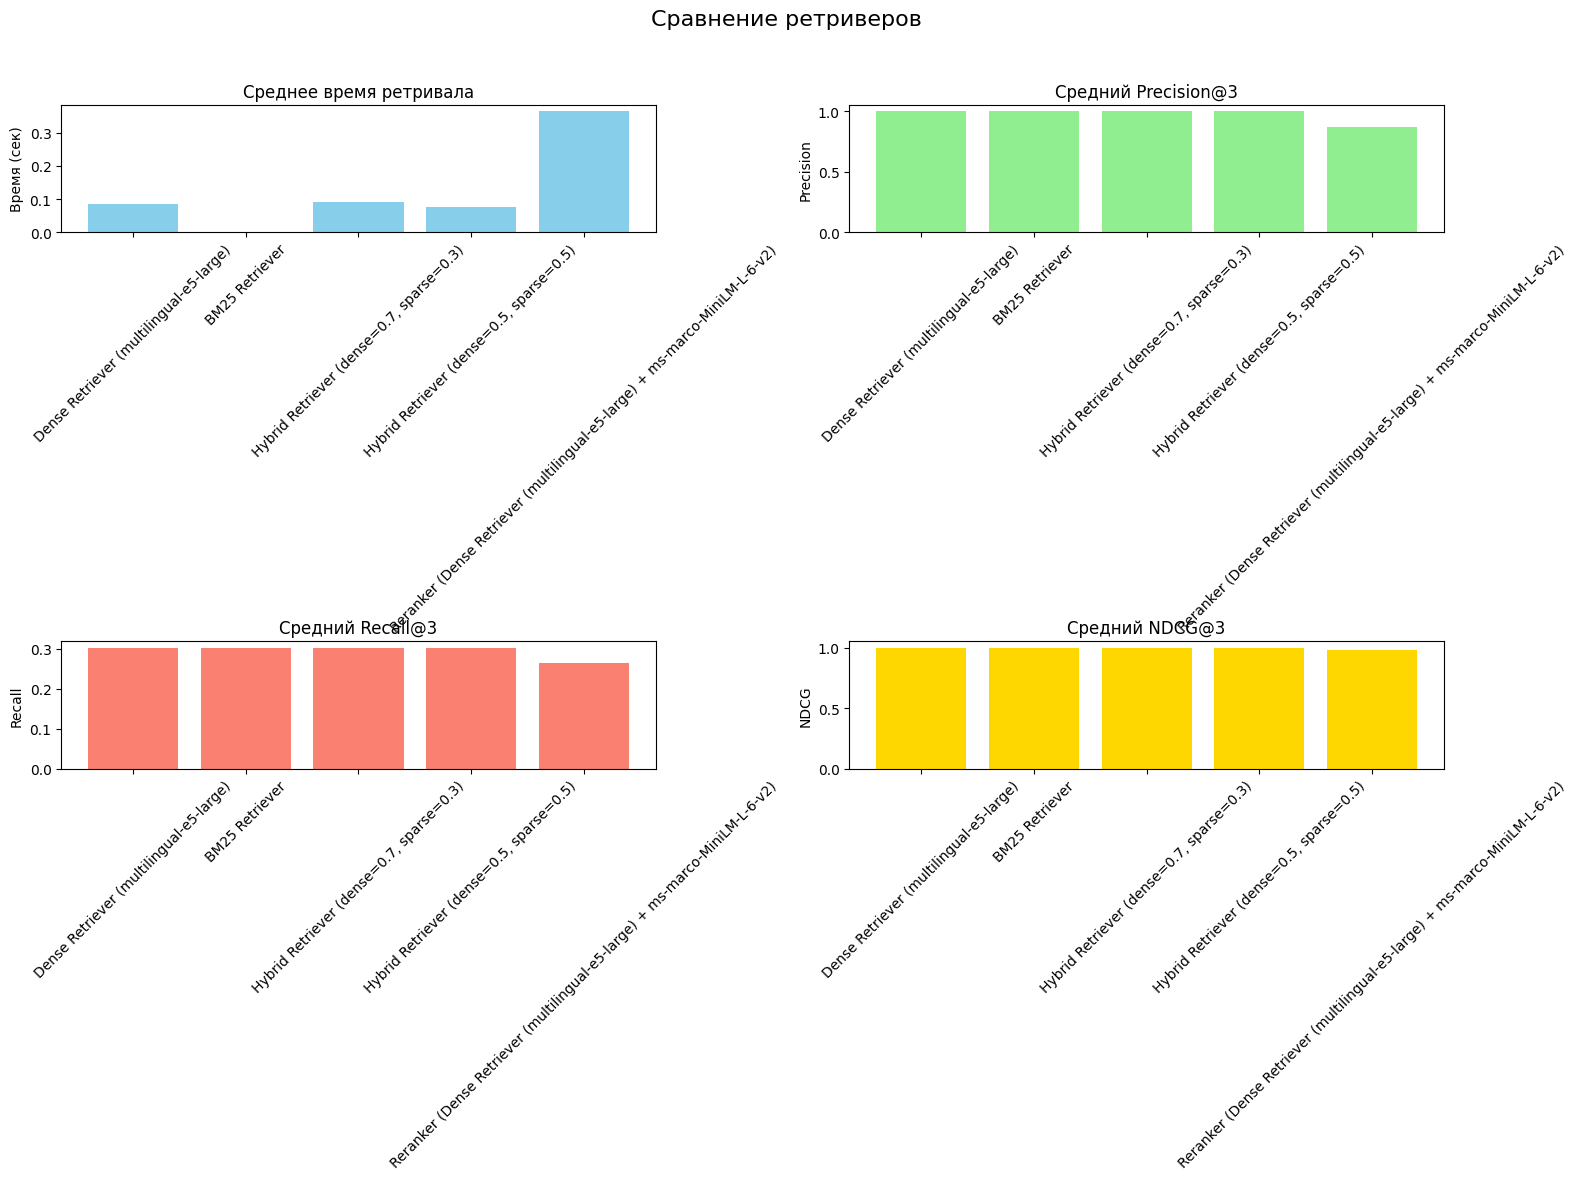


Таблица метрик:


,avg_time,max_time,min_time,avg_precision,avg_recall,avg_ndcg
Dense Retriever (multilingual-e5-large),0.084270,0.103056,0.069240,1.000000,0.303615,1.000000
BM25 Retriever,0.001055,0.002000,0.000000,1.000000,0.303615,1.000000
"Hybrid Retriever (dense=0.7, sparse=0.3)",0.090248,0.108262,0.083236,1.000000,0.303615,1.000000
"Hybrid Retriever (dense=0.5, sparse=0.5)",0.077174,0.091210,0.065153,1.000000,0.303615,1.000000
Reranker (Dense Retriever (multilingual-e5-large) + ms-marco-MiniLM-L-6-v2),0.365726,0.480243,0.212795,0.866667,0.263968,0.981546




Пример #1
Вопрос: What is a collection in the context of Qdrant?

Dense Retriever (multilingual-e5-large):
  1. [collections] (score: 0.8684): title: Collections weight: 30 aliases: - ../collections - /concepts/collections/ - /documentation/frameworks/fondant/documentation/concepts/collection...
  2. [points] (score: 0.8511): } python client.scroll( collection_name="{collection_name}", limit=15, order_by="timestamp", # <-- this! ) typescript client.scroll("{collection_name}...
  3. [collections] (score: 0.8494): ) client, err := qdrant.NewClient(&qdrant.Config{ Host: "localhost", Port: 6334, }) client.CreateCollection(context.Background(), &qdrant.CreateCollec...
  Precision: 1.0000, Recall: 0.2727, NDCG: 1.0000

BM25 Retriever:
  1. [explore] (score: 13.2903): Context is a set of positive-negative pairs, and each pair divides the space into positive and negative zones. In that mode, the search operation pref...
  2. [explore] (score: 12.0913): * When providing ids as examples, they 

Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Оценка Dense Retriever (multilingual-e5-large) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0859 сек

Тестирование модели: sentence-transformers/all-mpnet-base-v2
Инициализация DenseRetriever с моделью sentence-transformers/all-mpnet-base-v2...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Оценка Dense Retriever (all-mpnet-base-v2) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0310 сек

Тестирование модели: sentence-transformers/all-MiniLM-L6-v2
Инициализация DenseRetriever с моделью sentence-transformers/all-MiniLM-L6-v2...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Оценка Dense Retriever (all-MiniLM-L6-v2) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0105 сек

Тестирование модели: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Инициализация DenseRetriever с моделью sentence-transformers/paraphrase-multilingual-mpnet-base-v2...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Оценка Dense Retriever (paraphrase-multilingual-mpnet-base-v2) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0410 сек

3. Тестирование гибридных подходов с разными весами
Инициализация HybridRetriever (dense_weight=0.7, sparse_weight=0.3)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.7, sparse=0.3) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0860 сек
Инициализация HybridRetriever (dense_weight=0.5, sparse_weight=0.5)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.5, sparse=0.5) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0768 сек
Инициализация HybridRetriever (dense_weight=0.3, sparse_weight=0.7)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.3, sparse=0.7) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0878 сек
Инициализация HybridRetriever (dense_weight=0.8, sparse_weight=0.2)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Оценка Hybrid Retriever (dense=0.8, sparse=0.2) на 5 вопросах...


  0%|          | 0/5 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.0823 сек

4. Тестирование различных реранкеров
Инициализация RerankerRetriever с моделью cross-encoder/ms-marco-MiniLM-L-6-v2...
Инициализация HybridRetriever (dense_weight=0.7, sparse_weight=0.3)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Модель реранкера загружена
RerankerRetriever инициализирован
Оценка Reranker (Hybrid Retriever (dense=0.7, sparse=0.3) + ms-marco-MiniLM-L-6-v2) на 3 вопросах...


  0%|          | 0/3 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.3722 сек
Инициализация RerankerRetriever с моделью cross-encoder/ms-marco-TinyBERT-L-2-v2...
Инициализация HybridRetriever (dense_weight=0.7, sparse_weight=0.3)...
Инициализация DenseRetriever с моделью intfloat/multilingual-e5-large...


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован


Вычисление эмбеддингов:   0%|          | 0/3 [00:00<?, ?it/s]

DenseRetriever инициализирован
Инициализация BM25Retriever...
BM25Retriever инициализирован
HybridRetriever инициализирован
Модель реранкера загружена
RerankerRetriever инициализирован
Оценка Reranker (Hybrid Retriever (dense=0.7, sparse=0.3) + ms-marco-TinyBERT-L-2-v2) на 3 вопросах...


  0%|          | 0/3 [00:00<?, ?it/s]

Средняя скорость ретривала: 0.1000 сек

=== Итоговая сводка результатов ===
Средняя скорость ретривала:
Dense Retriever (multilingual-e5-large): 0.0843 сек
BM25 Retriever: 0.0011 сек
Hybrid Retriever (dense=0.7, sparse=0.3): 0.0902 сек
Hybrid Retriever (dense=0.5, sparse=0.5): 0.0772 сек
Reranker (Dense Retriever (multilingual-e5-large) + ms-marco-MiniLM-L-6-v2): 0.3657 сек

Для ручной оценки качества результатов:


=== Вопрос #1 ===
Вопрос: What is a collection in the context of Qdrant?

--- Dense Retriever (multilingual-e5-large) ---

Документ 1. [collections] (score: 0.8684):
title: Collections weight: 30 aliases: - ../collections - /concepts/collections/ - /documentation/frameworks/fondant/documentation/concepts/collections/

Collections A collection is a named set of points (vectors with a payload) among which you can search. The vector of each point within the same collection must have the same dimensionality and be compared by a single metric. Named vectors can be used to have m

In [ ]:
# Запускаем полную оценку
evaluation_results = evaluate_and_choose_best_approach()

# Выводим итоговые рекомендации
best_retriever_type = evaluation_results['best_retriever_type']
print(f"\n\n=== ИТОГОВЫЕ РЕКОМЕНДАЦИИ ===")
print(f"На основе проведенных экспериментов, рекомендуемый подход: {best_retriever_type.upper()}")

if best_retriever_type == "hybrid":
    print("\nРекомендации по использованию Hybrid Retriever:")
    print("1. Используйте комбинацию Dense и Sparse ретриверов с весами 0.7 и 0.3 соответственно")
    print("2. Для Dense компонента используйте модель intfloat/multilingual-e5-large")
    print("3. Для дальнейшего улучшения качества можно добавить реранкер")
elif best_retriever_type == "dense":
    print("\nРекомендации по использованию Dense Retriever:")
    print("1. Используйте модель intfloat/multilingual-e5-large для лучшего качества")
    print("2. Для ускорения можно использовать более легкие модели, например all-MiniLM-L6-v2")
elif best_retriever_type == "reranker":
    print("\nРекомендации по использованию Reranker Retriever:")
    print("1. Используйте HybridRetriever в качестве базового ретривера")
    print("2. Для реранкера используйте модель cross-encoder/ms-marco-MiniLM-L-6-v2")
    print("3. Для ускорения процесса можно уменьшить число кандидатов до 5-7")
elif best_retriever_type == "splade":
    print("\nРекомендации по использованию SPLADE Retriever:")
    print("1. Используйте модель naver/splade-cocondenser-ensembledistil")
    print("2. Требует больше вычислительных ресурсов, но дает высокое качество")
else:
    print("\nРекомендации по использованию BM25 Retriever:")
    print("1. Хорошо работает для точного поиска по ключевым словам")
    print("2. Рекомендуется комбинировать с Dense ретривером для лучших результатов")

print("\nКод для использования выбранного подхода:")
print(f"""
# Пример использования выбранного ретривера
from pipeline_file import ArticleDownloader, TextPreprocessor

# Создаем улучшенную QA систему с выбранным подходом
qa_system = EnhancedDocumentationQA(retriever_type="{best_retriever_type}")

# Инициализируем систему
qa_system.initialize()

# Используем для ответа на вопросы
question = "Что такое Qdrant Collection?"
answer = qa_system.get_answer(question)
print(answer)
""")